In [1]:
from googleapiclient.discovery import build
import config
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy
from sqlalchemy import MetaData
import requests
import missingno as msno
from matplotlib import rc_context
from matplotlib import ticker as tick
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from scipy import stats
import datetime as dt
import time
from datetime import date
sns.set(style="darkgrid")
import warnings
warnings.simplefilter("ignore")

In [2]:
API_KEY = config.API_KEY
CHANNEL_ID = 'UC0WNX0de8I1fgKUrjxiPaRA'
#tutorial UCW8Ews7tdKKkBT6GdtQaXvQ
#BlindRun UC0WNX0de8I1fgKUrjxiPaRA
S_DATE = '2017-04-19'
E_DATE = '2022-04-19'
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)
ENG_CONFIG = f"mysql://{config.DB_USER}:{config.DB_PASS}@{config.DB_HOST}:{config.DB_PORT}/{config.DB_NAME}"


In [3]:
youtube = build('youtube', 'v3', developerKey= API_KEY)


In [29]:
def fetch_channel_stats(youtube, CHANNEL_ID):
    all_data = []
    request = youtube.channels().list(
                part="snippet,contentDetails,statistics",
                id=CHANNEL_ID)
    response = request.execute()
    
    for i in range(len(response['items'])):
        data = dict(Channel_name=response['items'][i]['snippet']['title'],
                    Subscriber = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    Total_videos = response['items'][i]['statistics']['videoCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    return data

In [30]:
my_channel = fetch_channel_stats(youtube, CHANNEL_ID)

In [32]:
df = pd.DataFrame(my_channel, index=[0])

In [34]:
df.head()

,Channel_name,Subscriber,Views,Total_videos,playlist_id
0,Son of a Tech,176000,25728793,1540,UU0WNX0de8I1fgKUrjxiPaRA


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Channel_name  1 non-null      object
 1   Subscriber    1 non-null      object
 2   Views         1 non-null      object
 3   Total_videos  1 non-null      object
 4   playlist_id   1 non-null      object
dtypes: object(5)
memory usage: 48.0+ bytes


In [36]:
df['Subscriber'] = pd.to_numeric(df['Subscriber'])
df['Views'] = pd.to_numeric(df['Views'])
df['Total_videos'] = pd.to_numeric(df['Total_videos'])


In [38]:
df.head()

,Channel_name,Subscriber,Views,Total_videos,playlist_id
0,Son of a Tech,176000,25728793,1540,UU0WNX0de8I1fgKUrjxiPaRA


In [52]:
playlist_id = df.loc[df['Channel_name'] == 'Son of a Tech', 'playlist_id'].iloc[0]

In [53]:
playlist_id

'UU0WNX0de8I1fgKUrjxiPaRA'

In [69]:
# Video ids
def get_video_ids(youtube, playlist_id):
    request = youtube.playlistItems().list(
                part="contentDetails",
                playlistId=playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
    
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part="contentDetails",
                        playlistId=playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute() 
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
    
            next_page_token = response.get('nextPageToken')
    
    return video_ids

In [70]:
video_ids = get_video_ids(youtube, playlist_id)

In [71]:
video_ids

['CXEfl3D9juM',
 '4U7NSNWNbMY',
 'dVr867AC9fA',
 '7aTkYP2DoZ4',
 'j7clspfC-_o',
 'mAcnUUnpYS4',
 '4OBGxFA5onY',
 'MMNoGaYyoyA',
 'WKhkVx28Pgo',
 'OwLk7lCTK3I',
 'RvHTENTgakI',
 'JnZE9z2pDLg',
 'OiLxtdC9R9Y',
 '-S3PdvahOyY',
 '3PZGKpXipdA',
 'GbG9QBhKLjk',
 '-q6NdNh0ux4',
 'dvak_oXkiZY',
 'MVV03vJpM6Q',
 'afjzA5ZsVYY',
 'Dcsca32uhek',
 'EILKij5DpLw',
 'sJj8QQ00pRI',
 'MMNShnP7ELU',
 '5Gf2TXmNweg',
 'CG9XEsLh_I4',
 'mT5jorsbyRE',
 'IAN4kqGLO8s',
 '6tSQfZma-pc',
 'Qhis7prnQQA',
 'owOhevKcqjg',
 '-f50syuyubg',
 'DvzpvHRKP3o',
 'F7Bbxi6BiMY',
 'wI12IjwFIto',
 'kfratFAI-pA',
 'yq7nJx2qbp0',
 'RHjbcYusS58',
 'oJReSMUgz1Q',
 'cX_vPntrHvM',
 'tvq1NW8uofc',
 'I4QOt1GBKnY',
 'HqcIMRnRYs4',
 'UtxTaGYqV3I',
 'KXx8wWjh0q4',
 'oQk-xYsPfUk',
 'zEi-Z7LUfXs',
 '7A8Rj0UFONY',
 'Fz1z_v5BmGA',
 '4rsZQoJnGto',
 '4qjFsGPqh68',
 '1707gULNl4I',
 'KEuh51KroDA',
 'tD8pkdBuyuA',
 'j0cT5ppkQLI',
 'MZaoRfFgSRU',
 'rGGv3E4dy1Q',
 'UPOC8A-7ajQ',
 'hl_mtxPQcSo',
 'WOFK8YqUzwE',
 'votJS1-U-W8',
 'g2TpeWer5qg',
 'lNz4O3

## Function to get video stats

In [81]:
def get_video_details(youtube, video_ids):

    all_video_stats = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                    part="snippet,contentDetails,statistics",
                    id=','.join(video_ids[i:i+50]))
        response = request.execute()
        for video in response['items']:
            video_stats = dict(Title= video['snippet']['title'],
                              Published_date= video['snippet']['publishedAt'],
                              Views= video['statistics']['viewCount'],
                              Likes= video['statistics']['likeCount'],
                              Comments= video['statistics']['commentCount'])
            all_video_stats.append(video_stats)
    return all_video_stats

In [84]:
video_details = get_video_details(youtube, video_ids)

In [85]:
video_data = pd.DataFrame(video_details)

In [88]:
video_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           1540 non-null   object
 1   Published_date  1540 non-null   object
 2   Views           1540 non-null   object
 3   Likes           1540 non-null   object
 4   Comments        1540 non-null   object
dtypes: object(5)
memory usage: 60.3+ KB


In [115]:
#upload_date = str(upload_date).split("T")[0]
video_data['Published_date'] = pd.to_datetime(video_data['Published_date'], format='%m-%d-%Y')
video_data = video_data.astype({'Views':'int64','Likes':'int64','Comments':'int64'})

In [118]:
video_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Title           1540 non-null   object        
 1   Published_date  1540 non-null   datetime64[ns]
 2   Views           1540 non-null   int64         
 3   Likes           1540 non-null   int64         
 4   Comments        1540 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 60.3+ KB


In [122]:
top10_videos = video_data.sort_values(by='Views', ascending=False).head(10)

In [123]:
top10_videos

,Title,Published_date,Views,Likes,Comments
737,How to Mine Ethereum on Windows 10 | 2021 Guide,2021-01-01,1524607,37981,7522
712,How To Mine DogeCoin,2021-01-29,465982,5962,1169
715,Don't Use Nicehash | 2021 edition,2021-01-26,394454,6485,1624
693,Making $400 a Day Mining Ethereum,2021-02-14,359666,8182,2758
1302,5 Settings For Mining Cryptocurrency On Window...,2017-08-12,282551,6544,396
485,How to Create an NFT on OpenSea,2021-08-02,253691,4658,322
1292,How to Run Dual Power Supplies on Your Mining Rig,2017-08-23,217369,2924,289
748,How to Mine Ravencoin on Windows 10 | 2020,2020-12-05,211791,4271,630
672,Best Crypto Mining Pool 2021 | Payout Methods ...,2021-02-25,206681,3854,666
705,Easiest Coin To Mine on a Gaming Rig,2021-02-02,189949,5200,699


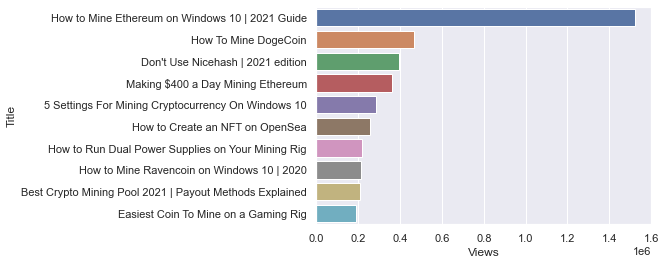

In [124]:
ax1 = sns.barplot(x='Views', y='Title', data=top10_videos)

In [125]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')

In [130]:
videos_per_month = video_data.groupby('Month', as_index=False).size()

In [131]:
videos_per_month

,Month,size
0,Apr,172
1,Aug,107
2,Dec,119
3,Feb,191
4,Jan,186
5,Jul,104
6,Jun,80
7,Mar,230
8,May,74
9,Nov,99


In [132]:
sort_order = ['Jan','Feb','Mar','Apr','May','Jun',
             'Jul','Aug','Sep','Oct','Nov','Dec']

In [133]:
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories=sort_order,ordered=True)

In [135]:
videos_per_month = videos_per_month.sort_index()

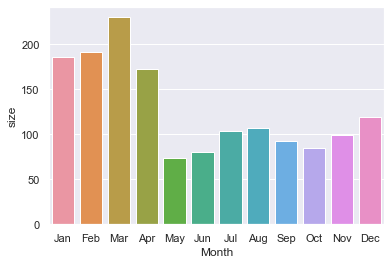

In [136]:
ax2 = sns.barplot(x='Month', y='size', data=videos_per_month)

In [91]:
df_temp['Date'] = pd.to_datetime(df_temp['Date'], unit='s').dt.normalize()
df = df_temp.astype({'Views':'int64','Likes':'int64','Comments':'int64'})

NameError: name 'df_temp' is not defined

In [ ]:
df = pd.DataFrame(columns=['video_id','video_title','upload_date','view_count','like_count','comment_count'])

In [ ]:
    def get_stats(video_id): 
    
        url_video_stats = "https://www.googleapis.com/youtube/v3/videos?id="+video_id+"&part=statistics&key="+API_KEY
        response_video_stats = requests.get(url_video_stats).json()
        view_count = response_video_stats['items'][0]['statistics']['viewCount']
        like_count = response_video_stats['items'][0]['statistics']['likeCount']
        comment_count = response_video_stats['items'][0]['statistics']['commentCount']
        
        return view_count, like_count, comment_count

In [ ]:
def get_vids(df):
    #make an api call
    pageToken = ""
    nextPageToken = ""
    #CDIQAA
    url = "https://www.googleapis.com/youtube/v3/search?key="+API_KEY+"&channelId="+CHANNEL_ID+"&part=snippet&id&order=date&maxResults=10000&"+pageToken
    response = requests.get(url).json()
    print(response)
    time.sleep(1)
    
    for video in response['items']:
        if video['id']['kind'] == 'youtube#video':
            video_id = video['id']['videoId']
            video_title = video['snippet']['title']
            #video_title = str(video_title).replace("&amp;","") format string as necessary
            upload_date = video['snippet']['publishedAt']
            upload_date = str(upload_date).split("T")[0]

            view_count, like_count, comment_count = get_stats(video_id)

            df = df.append({'video_id':video_id,'video_title':video_title,'upload_date':upload_date,
                            'view_count':view_count,'like_count':like_count,'comment_count':comment_count}
                             , ignore_index = True)
    return(df)

In [ ]:
1586

In [ ]:
df = get_vids(df)



In [ ]:
df.info()

In [ ]:
df['upload_date'] = pd.to_datetime(df['upload_date'])

In [ ]:
df.info()

In [ ]:
df.sort_values(by='upload_date')
df.drop_duplicates(subset ="video_title", keep = False, inplace = True)

In [ ]:
df.info()

In [ ]:
def connect_to_db(host_name, dbname, port, username, password):
    try:
        conn = ps.connect(host= host_name, dbname= dbname, user=username, password= password, port=port)

    except ps.OperationalError as e:
        raise e

    else:
        print('Connected!')
        
        return conn

In [ ]:
#create the table
def create_table(curr):
    create_table_command = ("""CREATE TABLE IF NOT EXISTS videos (
                            video_id VARCHAR(255) PRIMARY KEY,
                            video_title TEXT NOT NULL,
                            upload_date DATE NOT NULL DEFAULT CURRENT_DATE,
                            view_count INTEGER NOT NULL,
                            like_count INTEGER NOT NULL,
                            comment_count INTEGER NOT NULL
                            )""")
    curr.execute(create_table_command)

In [ ]:
def check_if_video_exists(curr, video_id):
    query= ("""SELECT video_id FROM VIDEOS WHERE video_id = %s""")
    curr.execute(query, (video_id,))
    
    return curr.fetchone() is not None

In [ ]:
def update_row(curr, video_id, video_title, upload_date, view_count, like_count, comment_count):
    query = ("""UPDATE videos
            SET video_title = %s,
                view_count = %s,
                like_count = %s,
                comment_count = %s
            WHERE video_id = %s;""")
    vars_to_update = (video_id, video_title, upload_date, view_count, like_count, comment_count)
    curr.execute(query, vars_to_update)

In [ ]:
def update_db(curr,df):
    tmp_df = pd.DataFrame(columns=['video_id','video_title','upload_date','view_count','like_count','comment_count'])

    for i, row in df.iterrows():
        if check_if_video_exists(curr, video_id):
            update_row(curr, row['video_id'], row['video_title'], row['upload_date'], row['view_count'], row['like_count'], row['comment_count'])
        else:
            tmp_df = tmp_df.append(row)
            
    return tmp_df

In [ ]:
def insert_into_table(curr, video_id, video_title, upload_date, view_count, like_count, comment_count):
    insert_into_videos = ("""INSERT INTO videos (video_id, video_title, upload_date, view_count, like_count, comment_count)
                         VALUES(%s, %s,%s,%s,%s,%s);""")
    row_to_insert = (video_id, video_title, upload_date, view_count, like_count, comment_count)
    curr.execute(insert_into_videos, row_to_insert)

In [ ]:
def append_from_df_to_db(curr,df):
    for i, row in df.iterrows():
        insert_into_table(curr, row['video_id'], row['video_title'], row['upload_date'], row['view_count'], row['like_count'], row['comment_count'])

In [ ]:

#conn = None

In [ ]:
conn = connect_to_db(config.DB_HOST, config.DB_NAME, config.DB_PORT, config.DB_USER, config.DB_PASS)

In [ ]:
curr = conn.cursor()

In [ ]:
create_table(curr)

In [ ]:
new_vid_df = update_db(curr,df)

In [ ]:
append_from_df_to_db(curr,new_vid_df)

In [ ]:
conn.commit()

In [ ]:
df.head()